# Bank transaction classifier
## Data cleaning

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [26]:
%%time

#def import_data(file):
#    """create a dataframe and optimize its memory usage"""
#    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
#    df = reduce_mem_usage(df)
#    return df

# import training and test data
PATH_train = (r'assets\santander\train.csv')
PATH_test = (r'assets\santander\test.csv')

train_data = pd.read_csv(PATH_train, index_col=None)
test_data = pd.read_csv(PATH_test, index_col=None)

df_train_raw = pd.DataFrame(train_data)
df_test_raw = pd.DataFrame(test_data)

display(df_train_raw.head())

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Wall time: 3min 16s
Parser   : 258 ms


In [27]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train_raw = reduce_mem_usage(df_train_raw)
df_test_raw = reduce_mem_usage(df_test_raw)

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 83.77 MB
Decreased by 72.8%
Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 83.58 MB
Decreased by 72.7%


### EDA

In [28]:
display(df_train_raw.shape)
display(df_test_raw.shape)

(200000, 202)

(200000, 201)

In [29]:
display(df_train_raw.info())
display(df_test_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: category(1), float16(200), int8(1)
memory usage: 83.8 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: category(1), float16(200)
memory usage: 83.6 MB


None

In [30]:
df_train_raw.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,-0.000000,NaN,NaN,NaN,NaN
std,0.300653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.408447,-15.046875,2.117188,-0.040192,5.074219,-32.562500,2.347656,5.351562,-10.507812,...,-14.093750,-2.691406,-3.814453,-11.781250,8.695312,-5.261719,-14.210938,5.960938,6.300781,-38.843750
25%,0.000000,8.453125,-4.738281,8.718750,5.253906,9.882812,-11.203125,4.769531,13.945312,-2.318359,...,-0.058830,5.156250,0.889648,0.584473,15.632812,-1.170898,-1.947266,8.250000,13.828125,-11.210938
50%,0.000000,10.523438,-1.608398,10.578125,6.824219,11.109375,-4.832031,5.386719,16.453125,0.393799,...,3.203125,7.347656,1.901367,3.396484,17.953125,-0.172729,2.408203,8.890625,15.937500,-2.820312
75%,0.000000,12.757812,1.358398,12.515625,8.320312,12.257812,0.924805,6.003906,19.109375,2.937500,...,6.406250,9.515625,2.949219,6.207031,20.390625,0.829590,6.558594,9.593750,18.062500,4.835938
max,1.000000,20.312500,10.375000,19.359375,13.187500,16.671875,17.250000,8.445312,27.687500,10.148438,...,18.437500,16.718750,8.406250,18.281250,27.921875,4.273438,18.328125,12.000000,26.078125,28.500000


In [31]:
# drop ID_code feature
df_train_raw = df_train_raw.drop('ID_code', axis=1)
df_test_raw = df_test_raw.drop('ID_code', axis=1)

In [32]:
# view data types
df_train_raw.columns.to_series().groupby(df_train_raw.dtypes).groups

{dtype('int8'): Index(['target'], dtype='object'),
 dtype('float16'): Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
        'var_8', 'var_9',
        ...
        'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
        'var_196', 'var_197', 'var_198', 'var_199'],
       dtype='object', length=200)}

In [33]:
# view sum of NaN values
df_train_raw.isna().sum().sum()

0

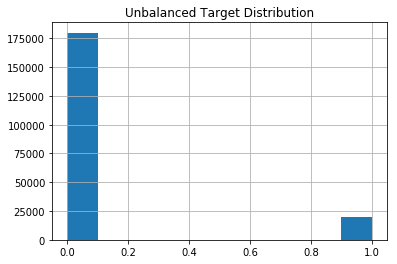

In [34]:
df_train_raw['target'].hist()
plt.title('Unbalanced Target Distribution')
plt.savefig('assets\ml_cap_target_unbal.png')
plt.show()

In [ ]:
#plt.figure(figsize=(12,4))
#plt.title("Average values of Features")
#sns.distplot(df_train_raw[features].mean(axis=0),color="magenta", kde=True,bins=120, label='train')
#sns.distplot(df_test_raw[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
#plt.legend()
#plt.savefig('assets\ml_cap_feature_dist_mean.png')
#plt.show()

In [ ]:
plt.figure(figsize=(12,4))
features = df_train_raw.drop('target', axis=1).columns.values
plt.title("Median values of Features")
sns.distplot(df_train_raw[features].median(axis=0),
             color="green",kde=True,bins=120, label='train')
sns.distplot(df_test_raw[features].median(axis=0),
             color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.savefig('assets\ml_cap_feature_dist_mid.png')
plt.show()

C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [ ]:
plt.figure(figsize=(12,4))
features = df_train_raw.drop('target', axis=1).columns.values
plt.title("Minimum values of Features")
sns.distplot(df_train_raw[features].min(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(df_test_raw[features].min(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.savefig('assets\ml_cap_feature_dist_min.png')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
features = df_train_raw.drop('target', axis=1).columns.values
plt.title("Max values of Features")
sns.distplot(df_train_raw[features].max(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(df_test_raw[features].max(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.savefig('assets\ml_cap_feature_dist_max.png')
plt.show()

In [61]:
#plt.figure(figsize=(12,4))
#plt.title("Skew of Features")
#sns.distplot(df_train_raw[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
#sns.distplot(df_test_raw[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
#plt.legend()
#plt.savefig('assets\ml_cap_feature_dist_skew.png')
#plt.show()

In [60]:
#plt.figure(figsize=(16,6))
#plt.title("Kurtosis of Features")
#sns.distplot(df_train_raw[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
#sns.distplot(df_train_raw[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
#plt.legend()
#plt.savefig('assets\ml_cap_feature_dist_kurtosis.png')
#plt.show()

### Train, test, split

In [11]:
#
data = df_train_raw.drop('target', axis=1)
target = df_train_raw['target']
features = [c for c in data.columns]
#
X_train = data
y_train = target
X_test = df_test_raw
y_test = pd.DataFrame()

In [12]:
data.shape

(200000, 200)

### Check for correlation

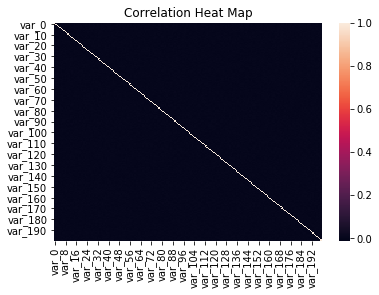

Wall time: 39 s


In [13]:
%%time

# plot a heatmap
sns.heatmap(data.corr())
plt.title('Correlation Heat Map')
plt.savefig('assets\ml_cap_corr_mat.png')
plt.show()

In [14]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display(data.shape)

# Drop correlated features 
for i in to_drop:
    data = data.drop(i, axis=1)

data.shape

(200000, 200)

(200000, 200)

### T-Test filtering

In [15]:
%%time

#
from scipy.stats import chi2_contingency
#
def ttest_filter(data, target):
    '''
    '''
    feature_list = []
    for feature in data:
        cont = pd.crosstab(data[feature], target)
        chi2_res = chi2_contingency(cont)
        # filter P-value
        if chi2_res[1] <= 0.05:
            feature_list.append(feature)
    return data[feature_list]
            
#
display(X_train.shape)
X_train_filt = ttest_filter(X_train, y_train)
X_test_filt = X_test[X_train_filt.columns.values]
display(X_train_filt.shape)

(200000, 200)

(200000, 131)

Wall time: 31.4 s


### Balance target variable

In [16]:
print('Target variable count:', target.sum())
print('Total observations:', len(target))
print('Target class:', target.sum()/len(target)*100, '%')

Target variable count: 20098
Total observations: 200000
Target class: 10.049 %


Target variable count: 20098
Total observations: 200000
Target class: 10.049 %


C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


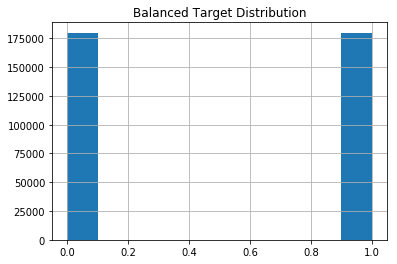

Wall time: 7min 38s


In [17]:
%%time
print('Target variable count:', target.sum())
print('Total observations:', len(target))
print('Target class:', target.sum()/len(target)*100, '%')
#
from imblearn import over_sampling as os
sm = os.SMOTE(random_state=42)
features = [c for c in X_train_filt.columns]
X_train_bal, y_train_bal = sm.fit_sample(X_train_filt, y_train.ravel())
X_train_bal = pd.DataFrame(X_train_bal, columns=features)
y_train_bal = pd.DataFrame(y_train_bal)

#
y_train_bal.hist()
plt.title('Balanced Target Distribution')
plt.savefig('assets\ml_cap_target_bal.png')
plt.show()

### Scale data

In [18]:
%%time

# scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# fit transform X_train
X_train_scaled = scaler.fit_transform(X_train_bal.astype(np.float64))
# transform X_test
X_test_scaled = scaler.transform(X_test_filt)

Wall time: 4.48 s


### PCA

In [19]:
%%time

# import and apply PCA
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.90)
# fit PCA on training set
X_train_pca = pca.fit_transform(X_train_scaled)
# transform test set
X_test_pca = pca.transform(X_test_scaled)
# convert numpy arrays to dataframe
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
#
features_pca = [c for c in X_train_pca.columns]
# find components
print(pca.n_components_)

### Store clean data

In [20]:
%%time

#
X_train = X_train_pca
y_train = y_train_bal.rename(columns={0:'target'})
X_test = X_test_pca
y_test = y_test
features = features_pca

#
df_train_clean = pd.concat([y_train, X_train], axis=1)
df_test_clean = X_test

#
#df_train_clean.to_csv('assets/santander/train_clean.csv', index=True)
#df_test_clean.to_csv('assets/santander/test_clean.csv', index=True)

Wall time: 12min 49s
Parser   : 244 ms
